### Instructions:
Execute this notebook to obtain a CNN model trained for classification on the cifar10 dataset. The model will be saved in the same directory as this notebook as "cifar_net.pth"

> CIFAR10 dataset has 10 classes - ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

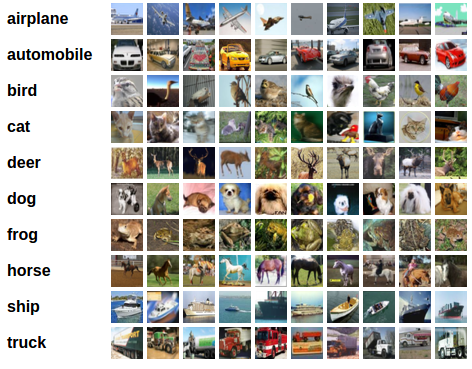

# Selecting device

In [1]:
import torch 

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

# Loading and normalizing images using TorchVision


In [2]:
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 57908381.83it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Displaying some images

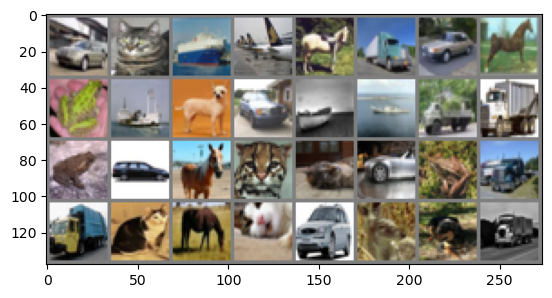

  car   cat  ship plane


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Defining a Convolutional Neural Network

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 256, 3).to(device)
        self.pool = nn.MaxPool2d(2, 2).to(device)
        self.bn1 = nn.BatchNorm2d(256).to(device)
        self.conv2 = nn.Conv2d(256, 512, 3).to(device)
        self.bn2 = nn.BatchNorm2d(512).to(device)
        self.conv3 = nn.Conv2d(512, 1024, 3).to(device)
        self.bn3 = nn.BatchNorm2d(1024).to(device)
        self.fc1 = nn.Linear(1024 * 2 * 2, 2048).to(device)
        self.fc2 = nn.Linear(2048, 512).to(device)
        self.fc3 = nn.Linear(512, 10).to(device)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)).to(device))
        x = self.bn1(x)
        x = self.pool(F.relu(self.conv2(x)).to(device))
        x = self.bn2(x)
        x = self.pool(F.relu(self.conv3(x)).to(device))
        x = self.bn3(x)
        x = x.view(-1, 1024 * 2 * 2)
        x = F.relu(self.fc1(x)).to(device)
        x = F.relu(self.fc2(x)).to(device)
        x = self.fc3(x)
        x = nn.functional.log_softmax(x, dim=1).to(device)
        return x


net = Net()

In [6]:
total = 0
print('Trainable parameters:')
for name, param in net.named_parameters():
    if param.requires_grad:
        print(name, '\t', param.numel())
        total += param.numel()
print()
print('Total', '\t', total)

Trainable parameters:
conv1.weight 	 6912
conv1.bias 	 256
bn1.weight 	 256
bn1.bias 	 256
conv2.weight 	 1179648
conv2.bias 	 512
bn2.weight 	 512
bn2.bias 	 512
conv3.weight 	 4718592
conv3.bias 	 1024
bn3.weight 	 1024
bn3.bias 	 1024
fc1.weight 	 8388608
fc1.bias 	 2048
fc2.weight 	 1048576
fc2.bias 	 512
fc3.weight 	 5120
fc3.bias 	 10

Total 	 15355402


# Defining a Loss Function and optimizer
**We will use a classification Cross-Entropy loss and Adam optimizer**

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# Finally we will train our neural network

In [8]:
for epoch in range(40):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 1.538
[1,   400] loss: 1.270
[1,   600] loss: 1.156
[1,   800] loss: 1.038
[1,  1000] loss: 1.001
[1,  1200] loss: 0.938
[1,  1400] loss: 0.911
[2,   200] loss: 0.737
[2,   400] loss: 0.708
[2,   600] loss: 0.710
[2,   800] loss: 0.706
[2,  1000] loss: 0.677
[2,  1200] loss: 0.696
[2,  1400] loss: 0.682
[3,   200] loss: 0.466
[3,   400] loss: 0.467
[3,   600] loss: 0.506
[3,   800] loss: 0.492
[3,  1000] loss: 0.493
[3,  1200] loss: 0.508
[3,  1400] loss: 0.488
[4,   200] loss: 0.289
[4,   400] loss: 0.315
[4,   600] loss: 0.304
[4,   800] loss: 0.328
[4,  1000] loss: 0.339
[4,  1200] loss: 0.350
[4,  1400] loss: 0.317
[5,   200] loss: 0.163
[5,   400] loss: 0.158
[5,   600] loss: 0.190
[5,   800] loss: 0.214
[5,  1000] loss: 0.212
[5,  1200] loss: 0.232
[5,  1400] loss: 0.235
[6,   200] loss: 0.098
[6,   400] loss: 0.111
[6,   600] loss: 0.125
[6,   800] loss: 0.145
[6,  1000] loss: 0.144
[6,  1200] loss: 0.146
[6,  1400] loss: 0.160
[7,   200] loss: 0.065
[7,   400] 

# Now we will save our model

In [9]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

# Let's test the accuracy of the model

**Displaying an image from test set**

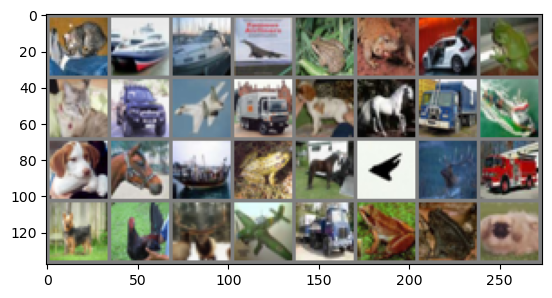

GroundTruth:    cat  ship  ship plane


In [10]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

**We will now see how the neural network predicts the above image**

In [11]:
images = images.to(device)
labels = labels.to(device)
outputs = net(images)

**The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:**

In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


**Let us look at how the network performs on the whole dataset.**

In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 78 %


**Let's see which classes performed well individually**

In [14]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item() 
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 80 %
Accuracy of   car : 89 %
Accuracy of  bird : 65 %
Accuracy of   cat : 56 %
Accuracy of  deer : 68 %
Accuracy of   dog : 78 %
Accuracy of  frog : 88 %
Accuracy of horse : 78 %
Accuracy of  ship : 87 %
Accuracy of truck : 88 %
